# 0: Import packages

In [120]:
from PIL import Image, ImageFile #pip install Pillow==9.4.0
import sys
import os
import numpy as np
import logging
import glob
import subprocess
import json
import pandas as pd

from ImageCrop import ImagePreprocessor
from SpotterWrapper import Spotter, PolygonVisualizer
from IPython.display import display
from shapely.geometry import Polygon

logging.basicConfig(level=logging.INFO)
Image.MAX_IMAGE_PIXELS=None
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 1: Specify filepaths

In [8]:
# Name folders for raw data and processed data
map_data_topfolder = 'raw_maps_20231024'
map_strec_topfolder = 'processed/strec'

for fp in [map_strec_topfolder]:
    if not os.path.isdir(fp):
        os.makedirs(fp)

# IMPORTANT! Locate spotter directory and detectron weights
git_clone_location = 'C:/Users/HP/'
model_weights = git_clone_location + 'detectron2-main/detectron2/checkpoint/model_v2_en.pth'
spotter_directory = git_clone_location + 'mapkurator-spotter-main/spotter-v2'
spotter_config = spotter_directory + '/configs/PALEJUN/Finetune/Base-SynthMap-Polygon.yaml'

# 2: Crop all jpeg maps in (user defined) map_data_topfolder

In [ ]:
def pyramid_scan(img_path, output_dir, save_each_layer=False):
    image = Image.open(img_path)
    image_preprocessor = ImagePreprocessor(image, overlapping_tolerance=0.2, num_layers=3, min_patch_resolution=256, max_patch_resolution=2048)
    image_preprocessor.process()
    print("preprocessing done")
    spotter = Spotter(spotter_config, model_weights, confidence_thresh=0.8, draw_thresh=0.85)
    all_layer_results = []

    base_image_batch, base_offset_xs, base_offset_ys = image_preprocessor.get_image_patches(0)
    vis = PolygonVisualizer()
    vis.canvas_from_patches(base_image_batch, base_offset_xs, base_offset_ys)

    for i in range(image_preprocessor.num_layers):
        # If you want to save for each layer, uncomment the following line
        # image_preprocessor.save_patches(os.path.join(output_dir, f'layer_{i}_patches'), layer=i)

        image_batch, offset_xs, offset_ys = image_preprocessor.get_image_patches(i)
        spotter.load_batch(image_batch, offset_xs, offset_ys)
        results = spotter.inference_batch()
        all_layer_results.extend(results)

        #all_layer_offset_xs.extend(offset_xs)
        #all_layer_offset_ys.extend(offset_ys)

        if save_each_layer == True:
            vis.draw(results).save(os.path.join(output_dir, f'combined_tagged_{i}.png'))
            vis.save_json(results, os.path.join(output_dir, f'combined_tagged_{i}.json'))
        else:
            pass

    vis.draw(all_layer_results).save(os.path.join(output_dir, f'combined_tagged_all_layers.png'))
    vis.save_json(all_layer_results, os.path.join(output_dir, f'combined_tagged_all_layers.json'))

# Run crop on all maps
for map_data_subfolder in next(os.walk(map_data_topfolder))[1]:
    jpeg_list = glob.glob(map_data_topfolder + '/' + map_data_subfolder + '/*.jpeg')
    if len(jpeg_list) != 1:
        print(map_data_subfolder + " failed. Please ensure there is exactly 1 file with extension .jpeg in the folder.")
    else:
        map_image = jpeg_list[0].split("\\")[1]
        if map_data_subfolder in ['1845_kiepert']: # '1818_sieber', '1874_saunders', '1845_kiepert']: #,,]: #'1858_vandevelde', '1847_tobler'
            img_path = map_data_topfolder + '/' + map_data_subfolder + "/" + map_image
            map_name = os.path.basename(img_path).split('.')[0] # get the map name without extension
            output_dir = os.path.join(map_strec_topfolder, map_name)
            if not os.path.isdir(output_dir):
                os.makedirs(output_dir)
            pyramid_scan(img_path, output_dir, save_each_layer=True)
            logging.info('Done cropping %s' %img_path )

# 3: Evaluation

map is 6529 pixels wide by 8695 pixels high.


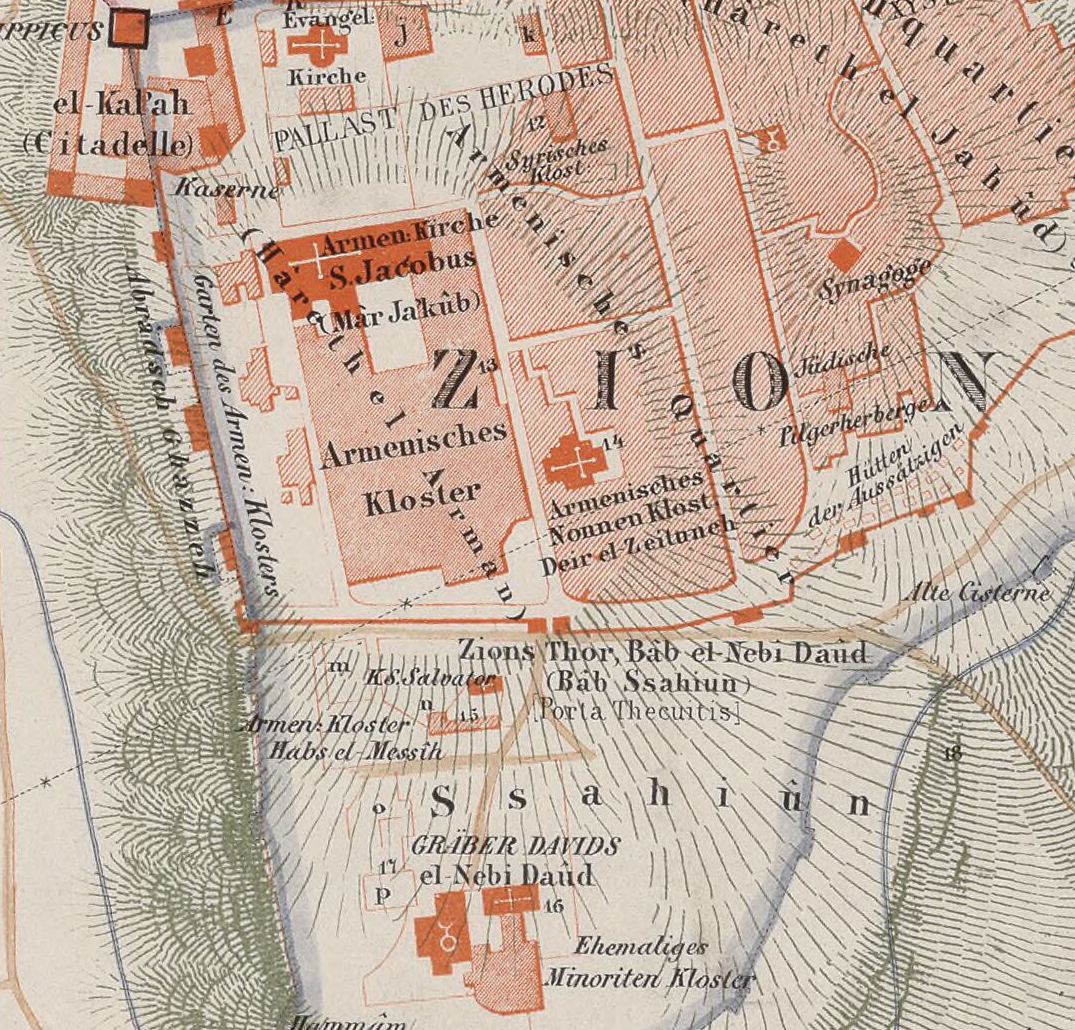

In [49]:
def visualize_crop(left_x, right_x, top_y, bottom_y):
    map_img = Image.open('raw_maps_20231024/1845_kiepert/kiepert_1845.jpeg') 
    width, height = map_img.size
    print("map is " + str(width) + " pixels wide by " + str(height) + " pixels high.")
    display(map_img.crop((left_x, top_y, right_x, bottom_y, )))

left_x = 2475
right_x = 3550
top_y = 4820
bottom_y = 5850

visualize_crop(left_x, right_x, top_y, bottom_y)

In [149]:
def coords_fail_condition(list, direction_for_drop, value, baseline):
    if baseline == 1:
        return 1
    else:
        if direction_for_drop == '<':
            num_coords_broke_rule = sum([0 if x < value else 1 for x in list])
        elif direction_for_drop == '>':
            num_coords_broke_rule = sum([0 if x > value else 1 for x in list])
        if num_coords_broke_rule > 0:
            return 1
        else:
            return 0
        
def retain_crop_label_only(df, left_x, right_x, top_y, bottom_y):
    df['drop'] = 0
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_x'], '>', left_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_x'], '<', right_x, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_y'], '>', top_y, row['drop']), axis=1)
    df['drop'] = df.apply(lambda row: coords_fail_condition(row['all_points_y'], '<', bottom_y, row['drop']), axis=1)
    df = df[df['drop'] == 0]
    return df

def create_polygon_object(x_coords, y_coords):
    return Polygon(zip(x_coords, y_coords))

In [150]:
with open('dependencies/ground_truth_labels/kiepert_1845.json') as f:
    gt_labels_tmp = json.load(f)
gt_labels = pd.DataFrame([
    {
        'all_points_x': obs['shape_attributes']['all_points_x'],
        'all_points_y': obs['shape_attributes']['all_points_y'],
        'annotation': obs['region_attributes']['annotation'],
        'multiline_g': obs['region_attributes'].get('multiline_g', None)
    }
    for obs in gt_labels_tmp[list(gt_labels_tmp.keys())[0]]['regions']
])

gt_labels_subset = retain_crop_label_only(gt_labels, left_x, right_x, top_y, bottom_y)
#gt_labels_subset['polygons'] = gt_labels_subset.apply(lambda row: create_polygon_object(row['all_points_x'], row['all_points_y']), axis=1)

In [ ]:
Polygon(list(zip(gt_labels_subset['all_points_x'][4], gt_labels_subset['all_points_y'][4])))

In [143]:
with open('processed/strec/kiepert_1845/combined_tagged_all_layers.json') as f:
    spotter_labels_tmp = json.load(f)
spotter_labels = pd.DataFrame(spotter_labels_tmp)
spotter_labels = spotter_labels.rename(columns={'polygon_x':'all_points_x','polygon_y':'all_points_y'})
spotter_labels_subset = retain_crop_label_only(spotter_labels, left_x, right_x, top_y, bottom_y)
spotter_labels_subset['polygons'] = spotter_labels_subset.apply(lambda row: create_polygon_object(row['all_points_x'], row['all_points_y']), axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_5336\3235243173.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotter_labels_subset['polygons'] = spotter_labels_subset.apply(lambda row: create_polygon_object(row['all_points_x'], row['all_points_y']), axis=1)
